In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from math import sqrt

In [ ]:
# Upload and load data
from google.colab import files
uploaded = files.upload()

Saving Titanium_Alloy_UC.csv to Titanium_Alloy_UC.csv


In [ ]:
# Load CSV
fatigue_df = pd.read_csv("Titanium_Alloy_UC.csv", encoding='unicode_escape')
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

Pearson CC: 0.9634
R2 Score: 0.9118
RMSE: 0.5565
MAE: 0.3768
Coverage: 88.64%
Interval Width: 1.5388
Composite Metric: 0.8272


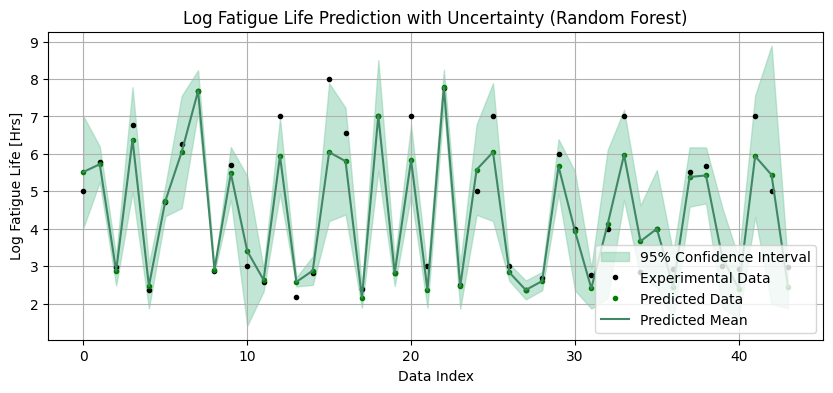

In [ ]:
#Define features and targets
drop_cols = ['Number of Cycles', 'SL. Number']
features = fatigue_df.drop(drop_cols, axis=1).astype('float64')
targets = np.log10(fatigue_df['Number of Cycles'])

# Split train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# Uncertainty Estimation
all_tree_preds = np.array([tree.predict(X_test) for tree in model.estimators_])
y_pred_unc_test = np.std(all_tree_preds, axis=0)

# Evaluation metrics
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y > yL) & (y < yH)))

df_test_low = y_pred_test - 2 * y_pred_unc_test
df_test_high = y_pred_test + 2 * y_pred_unc_test
df_test_median = y_pred_test

# Metrics calculation
pearson_cc = pearsonr(y_test, y_pred_test)[0]
r2 = r2_score(y_test, y_pred_test)
rmse = sqrt(mean_squared_error(y_test, y_pred_test))
mae = np.mean(abs(y_pred_test - y_test))
test_coverage = coverage(y_test, df_test_low, df_test_high)
interval_width = np.median(df_test_high - df_test_low)
composite_metric = 0.75 * test_coverage / 100 + 0.25 * (1 / interval_width)

# Print results
print(f"Pearson CC: {pearson_cc:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Coverage: {test_coverage:.2f}%")
print(f"Interval Width: {interval_width:.4f}")
print(f"Composite Metric: {composite_metric:.4f}")

# Plot prediction with uncertainty
fig, ax = plt.subplots(figsize=(10, 4))
indices = range(len(y_test))

ax.fill_between(indices, df_test_low, df_test_high, alpha=0.5, color='#86cfac', label='95% Confidence Interval')
ax.plot(indices, y_test, 'ko', markersize=3, label='Experimental Data')
ax.plot(indices, y_pred_test, 'go', markersize=3, label='Predicted Data')
ax.plot(indices, y_pred_test, '-', color='#408765', label='Predicted Mean')

ax.set_xlabel("Data Index")
ax.set_ylabel("Log Fatigue Life [Hrs]")
ax.set_title("Log Fatigue Life Prediction with Uncertainty (Random Forest)")
ax.legend(loc='lower right')
ax.grid(True)
plt.show()